# Import

In [150]:
import warnings                                                                                                #import libraries
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from time import process_time
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

%matplotlib inline

In [151]:
df = pd.read_csv('house_price_2.csv')

In [152]:
df.head(2)

,Index,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,...,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
0,0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,...,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,...,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN


In [153]:
df.drop(['Index'], axis=1, inplace=True)
df_train = df.loc[df['Price (in rupees)'].notna()]
df_test = df.loc[df['Price (in rupees)'].isna()]

In [154]:
print('Train dataset shape: ', df_train.shape)
print('Test dataset shape:  ', df_test.shape)

Train dataset shape:  (169866, 20)
Test dataset shape:   (17665, 20)


In [155]:
df_train = df_train.sample(frac=0.1)
df_train.reset_index(inplace=True)
df_train.drop(['index'], axis=1, inplace=True)

In [156]:
print('New train dataset shape: ', df_train.shape)

New train dataset shape:  (16987, 20)


In [157]:
df = pd.concat([df_train, df_test])

In [158]:
print('Full dataset shape: ', df.shape)

Full dataset shape:  (34652, 20)


# EDA

In [159]:
df_notna = df.notna().sum()
df_notna

Title                34652
Description          34232
Amount(in rupees)    34652
Price (in rupees)    16987
location             34652
Carpet Area          22594
Status               34571
Floor                33737
Transaction          34574
Furnishing           33609
facing               20358
overlooking          16805
Society              12634
Bathroom             34502
Balcony              26242
Car Parking          13261
Ownership            21561
Super Area           11231
Dimensions               0
Plot Area                0
dtype: int64

In [160]:
na_col = np.unique(df_notna, return_counts=True)
na_col

(array([    0, 11231, 12634, 13261, 16805, 16987, 20358, 21561, 22594,
        26242, 33609, 33737, 34232, 34502, 34571, 34574, 34652]),
 array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]))

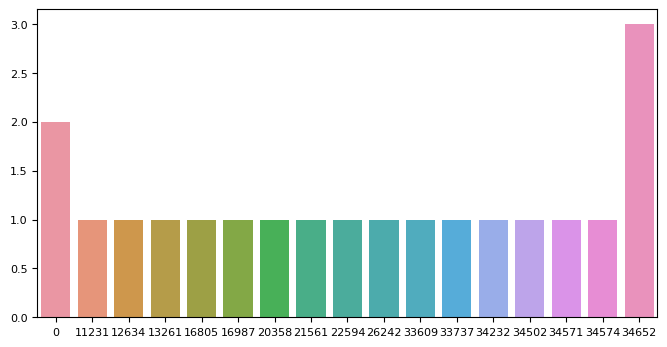

In [161]:
plt.figure(figsize=(8,4))
b = sns.barplot(x=na_col[0], y=na_col[1])
b.tick_params(labelsize=8)

In [162]:
for i in df.columns:
    if (df[i].notna().sum() < 0.5*len(df)) and (i != 'Price (in rupees)'):
        del(df[i])

In [163]:
df.shape

(34652, 14)

In [164]:
df_room_count = df['Title'].str.split(pat = ' BHK', expand = True)
df_flat_or_apartment = df['Title'].str.split(pat = ' for sale ', expand = True)
df_flat_or_apartment = df_flat_or_apartment[0].str.split(pat = 'Occupy ', expand = True)
df_flat_or_apartment[1].fillna(df_flat_or_apartment[0], inplace=True)

df_room_count = df_room_count[0]
df_flat_or_apartment = df_flat_or_apartment[1]

df = pd.concat([df, df_room_count, df_flat_or_apartment], axis=1)
df.drop(['Title'], axis=1, inplace=True)
df.rename(columns = {0:'Rooms_count', 1:'Flat_or_Apartment'}, inplace=True)

In [165]:
df.replace({'Rooms_count' : {'1': '1 ','2': '2 ','3': '3 ','4': '4 ','5': '5 ','6': '6 ','7': '7 ',
                             '8': '8 ','9': '9 ','10': '10 ','> 10': '11 '}}, inplace=True)
df_room_count = df['Rooms_count'].str.split(pat = ' ', expand = True)
df_room_count = df_room_count[0]
df = pd.concat([df, df_room_count], axis=1)
df.drop(['Rooms_count'], axis=1, inplace=True)
df.rename(columns = {0:'Rooms_count'}, inplace=True)
df[['Rooms_count']] = df[['Rooms_count']].apply(pd.to_numeric)

In [166]:
df_amount = df['Amount(in rupees)'].str.split(pat = ' ', expand = True)
df_amount_number = df_amount[0]
df_lac_or_cr = df_amount[1]
df = pd.concat([df, df_amount_number, df_lac_or_cr], axis=1)
df.drop(['Amount(in rupees)'], axis=1, inplace=True)
df.rename(columns = {0:'Amount'}, inplace=True)

In [167]:
df.replace({'Amount' : {'Call': 0}}, inplace=True)
df[['Amount']] = df[['Amount']].apply(pd.to_numeric)
df.replace({1 : {'Cr': 100, 'Lac': 1, 'for': 0}}, inplace=True)
df[[1]] = df[[1]].apply(pd.to_numeric)
df['Amount'] = df['Amount']*df[1]
df.drop([1], axis=1, inplace=True)
df.replace({'Amount' : {0 : np.NaN}}, inplace=True)

In [168]:
df_carpet_area = df['Carpet Area'].str.split(pat = ' ', expand = True)
df_carpet_area = df_carpet_area[0]
df = pd.concat([df, df_carpet_area], axis=1)
df.drop(['Carpet Area'], axis=1, inplace=True)
df.rename(columns = {0:'Carpet_area'}, inplace=True)
df[['Carpet_area']] = df[['Carpet_area']].apply(pd.to_numeric)
df['Carpet_area'].fillna(0, inplace=True)

In [169]:
df['Status'].fillna('Not Ready to Move', inplace=True)

In [170]:
df_floor = df['Floor'].str.split(pat = ' ', expand = True)
df_floors = df['Floor'].str.split(pat = 'of ', expand = True)
df_floor = df_floor[0]
df_floors = df_floors[1]
df = pd.concat([df, df_floor, df_floors], axis=1)
df.drop(['Floor'], axis=1, inplace=True)
df.rename(columns = {0:'Floor', 1:'Floors'}, inplace=True)

In [171]:
df.replace({'Floor' : {'Ground': 0, 'Lower': 0, 'Upper': df['Floors']}}, inplace=True)
df[['Floor', 'Floors']] = df[['Floor', 'Floors']].apply(pd.to_numeric)

In [172]:
df['Transaction'].fillna('Other', inplace=True)
df['Furnishing'].fillna('Unfurnished', inplace=True)

In [173]:
df.replace({'Bathroom' : {'> 10': 11}}, inplace=True)
df[['Bathroom']] = df[['Bathroom']].apply(pd.to_numeric)

In [174]:
df.replace({'Balcony' : {'> 10': 11}}, inplace=True)
df['Balcony'].fillna('0', inplace=True)
df[['Balcony']] = df[['Balcony']].apply(pd.to_numeric)

In [175]:
df_text = df['Description']
df.drop(['Description'], axis=1, inplace=True)

In [176]:
df

,Price (in rupees),location,Status,Transaction,Furnishing,facing,Bathroom,Balcony,Ownership,Flat_or_Apartment,Rooms_count,Amount,Carpet_area,Floor,Floors
0,6173.0,hyderabad,Ready to Move,Resale,Unfurnished,East,2.0,0,NaN,Flat,2.0,67.9,0.0,2.0,5.0
1,9695.0,gurgaon,Ready to Move,Resale,Unfurnished,NaN,3.0,3,NaN,Flat,3.0,175.0,1605.0,5.0,11.0
2,7588.0,gurgaon,Ready to Move,Resale,Furnished,East,3.0,3,Freehold,Flat,3.0,195.0,0.0,1.0,18.0
3,8033.0,bangalore,Ready to Move,Resale,Semi-Furnished,NaN,2.0,0,NaN,Flat,2.0,116.0,0.0,9.0,9.0
4,3877.0,bangalore,Ready to Move,Resale,Semi-Furnished,East,3.0,3,Freehold,Flat,3.0,63.0,1435.0,3.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187404,NaN,zirakpur,Ready to Move,Resale,Semi-Furnished,North,3.0,3,Freehold,Flat,3.0,NaN,1450.0,3.0,9.0
187442,NaN,zirakpur,Ready to Move,New Property,Semi-Furnished,North,3.0,2,Freehold,Flat,3.0,NaN,1200.0,2.0,4.0
187503,NaN,zirakpur,Ready to Move,New Property,Semi-Furnished,North - East,3.0,2,Co-operative Society,Flat,3.0,NaN,990.0,4.0,5.0
187506,NaN,zirakpur,Ready to Move,Resale,Furnished,East,4.0,4,Freehold,Flat,4.0,NaN,2500.0,6.0,7.0


# Categorical

In [177]:
df.dtypes

Price (in rupees)    float64
location              object
Status                object
Transaction           object
Furnishing            object
facing                object
Bathroom             float64
Balcony                int64
Ownership             object
Flat_or_Apartment     object
Rooms_count          float64
Amount               float64
Carpet_area          float64
Floor                float64
Floors               float64
dtype: object

In [178]:
df_g = pd.get_dummies(df, drop_first=True)
df_g.reset_index(inplace=True)
df_g.drop(['index'], axis=1, inplace=True)

In [179]:
df_g

,Price (in rupees),Bathroom,Balcony,Rooms_count,Amount,Carpet_area,Floor,Floors,location_ahmadnagar,location_ahmedabad,...,facing_South,facing_South - East,facing_South -West,facing_West,Ownership_Freehold,Ownership_Leasehold,Ownership_Power Of Attorney,Flat_or_Apartment_ Builder Floor,Flat_or_Apartment_ Studio Apartment,Flat_or_Apartment_Flat
0,6173.0,2.0,0,2.0,67.9,0.0,2.0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,9695.0,3.0,3,3.0,175.0,1605.0,5.0,11.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,7588.0,3.0,3,3.0,195.0,0.0,1.0,18.0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,8033.0,2.0,0,2.0,116.0,0.0,9.0,9.0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3877.0,3.0,3,3.0,63.0,1435.0,3.0,6.0,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34647,NaN,3.0,3,3.0,NaN,1450.0,3.0,9.0,0,0,...,0,0,0,0,1,0,0,0,0,1
34648,NaN,3.0,2,3.0,NaN,1200.0,2.0,4.0,0,0,...,0,0,0,0,1,0,0,0,0,1
34649,NaN,3.0,2,3.0,NaN,990.0,4.0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,1
34650,NaN,4.0,4,4.0,NaN,2500.0,6.0,7.0,0,0,...,0,0,0,0,1,0,0,0,0,1


# Fill in the gaps

In [180]:
df.isna().sum()

Price (in rupees)    17665
location                 0
Status                   0
Transaction              0
Furnishing               0
facing               14294
Bathroom               150
Balcony                  0
Ownership            13091
Flat_or_Apartment        0
Rooms_count            663
Amount                9684
Carpet_area              0
Floor                  915
Floors                 931
dtype: int64

In [181]:
start_time = process_time()

imp = IterativeImputer(max_iter=15, random_state=0)
imp.fit(df_g.iloc[:,1:].values)
df_g_it = imp.transform(df_g.iloc[:,1:].values)

finish_time = process_time()
time = finish_time - start_time
print(round(time, 2), 'sec')

135.02 sec


In [182]:
df_g_it

array([[2.        , 0.        , 2.        , ..., 0.        , 0.        ,
        1.        ],
       [3.        , 3.        , 3.        , ..., 0.        , 0.        ,
        1.        ],
       [3.        , 3.        , 3.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [3.        , 2.        , 3.        , ..., 0.        , 0.        ,
        1.        ],
       [4.        , 4.        , 4.        , ..., 0.        , 0.        ,
        1.        ],
       [2.78309456, 0.        , 3.        , ..., 0.        , 0.        ,
        1.        ]])

In [183]:
df2 = df_g_it

In [184]:
df3 = pd.DataFrame(data=df2, columns=df_g.iloc[:,1:].columns)
df3['Price'] = df_g['Price (in rupees)']

df3.head()

,Bathroom,Balcony,Rooms_count,Amount,Carpet_area,Floor,Floors,location_ahmadnagar,location_ahmedabad,location_allahabad,...,facing_South - East,facing_South -West,facing_West,Ownership_Freehold,Ownership_Leasehold,Ownership_Power Of Attorney,Flat_or_Apartment_ Builder Floor,Flat_or_Apartment_ Studio Apartment,Flat_or_Apartment_Flat,Price
0,2.0,0.0,2.0,67.9,0.0,2.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6173.0
1,3.0,3.0,3.0,175.0,1605.0,5.0,11.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9695.0
2,3.0,3.0,3.0,195.0,0.0,1.0,18.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7588.0
3,2.0,0.0,2.0,116.0,0.0,9.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8033.0
4,3.0,3.0,3.0,63.0,1435.0,3.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3877.0


# Future selection

<Axes: >

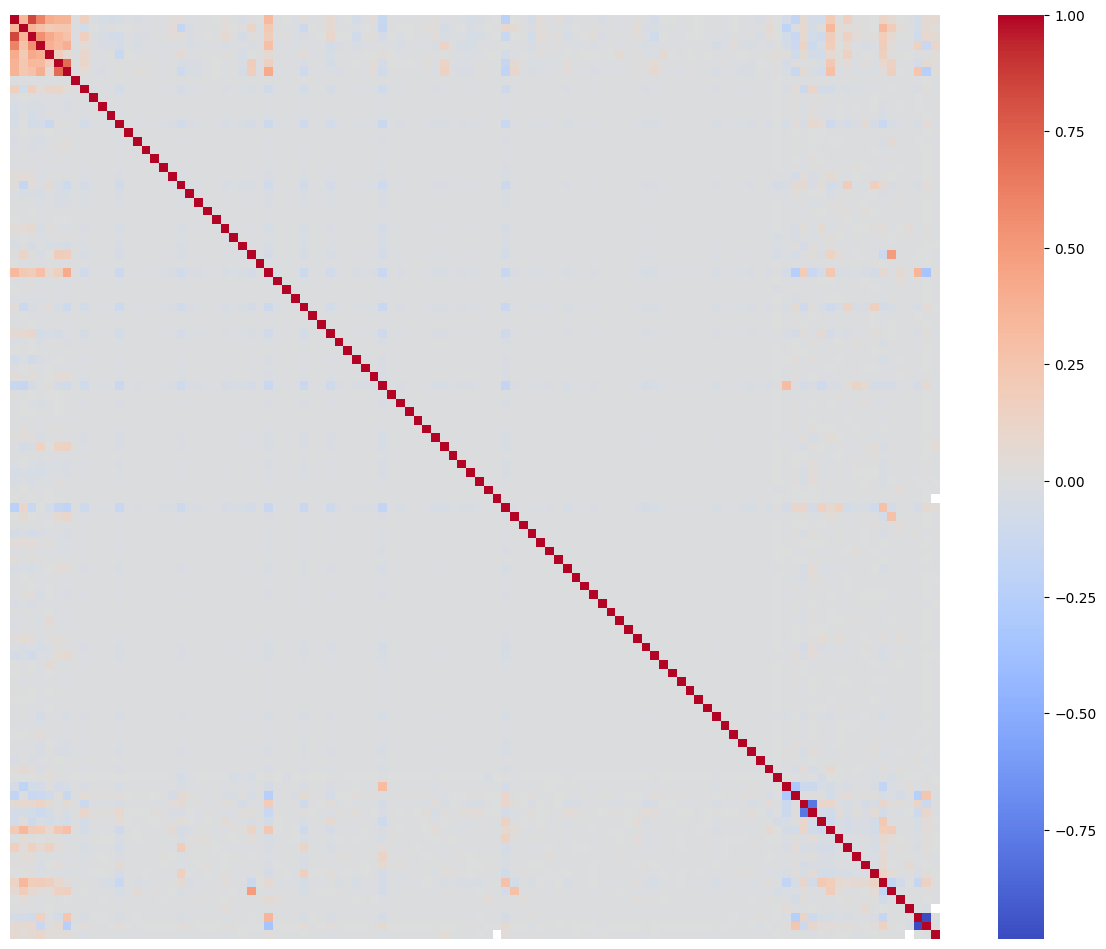

In [185]:
cor = df3.corr()

plt.figure(figsize=(15,12))
sns.heatmap(cor, xticklabels=False, yticklabels=False, cmap='coolwarm')

In [186]:
all_features = list(cor.columns)
f_to_del = []

for i in cor.columns:
    if i == 'Price':
        continue
    for j in cor.index:
        if all_features.index(j) >= all_features.index(i) or j == 'Price':
            continue
        else:
            if abs(cor.loc[i,j]) > 0.8:
                if abs(cor.loc['Price', i]) > abs(cor.loc['Price', j]):
                    f_to_del.append(j)
                else:
                    f_to_del.append(i)

In [187]:
f_to_del = set(f_to_del)
print(len(f_to_del))
f_to_del

2


{'Flat_or_Apartment_Flat', 'Rooms_count'}

In [188]:
for i in f_to_del:
    del df3[i]

In [189]:
df3.shape

(34652, 104)

# Text category

In [190]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [191]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower()
    text_words_list = text.split(' ')
    ps = PorterStemmer()
    stemmed_words=[]
    for w in text_words_list:
        if len(w)>0:
            if w not in stopwords.words('english'):
                stemmed_words.append(ps.stem(w))
    #return stemmed_words
    return ' '.join(stemmed_words)

In [192]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [193]:
df_text

0         One can find this stunning 2 BHK flat for sale...
1         Up for immediate sale is a 3 BHK apartment in ...
2         This lovely 3 BHK Flat in Sector 79, Gurgaon i...
3         This exquisite 2 BHK Flat is offered for sale ...
4         JP Nagar, Bangalore has an attractive 3 BHK Fl...
                                ...                        
187404    This gorgeous 3 BHK Flat is available for sale...
187442    Have a look at this immaculate 3 BHK flat for ...
187503    Up for immediate sale is a 3 BHK apartment in ...
187506    Carefully laid out in the prime location of Pe...
187513    This ready to move-in 3 BHK flat is available ...
Name: Description, Length: 34652, dtype: object

In [194]:
print(df_text[0])
print()
print(clean_text(df_text[0]))

One can find this stunning 2 BHK flat for sale in Alkapur Township, Hyderabad. This apartment for resale is a great choice. This ready to move flat in Alkapur Township comes at an affordable price of INR 67.9 Lac. It is unfurnished to accommodate your needs.

one find stun 2 bhk flat sale alkapur township hyderabad apart resal great choic readi move flat alkapur township come afford price inr 679 lac unfurnish accommod need


In [195]:
df_text = df_text.apply(clean_text)

In [196]:
print(df_text.apply(len).min())
print(df_text.apply(len).mean())
print(df_text.apply(len).max())

3
225.53119589056908
2203


In [197]:
word_embeddings = {}

with open("glove.6B.100d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    f.close()

In [198]:
sum([word_embeddings.get(w, np.zeros((100,))) for w in df_text[0].split()])/(len(df_text[0].split())+0.001)

array([-0.0335933 ,  0.15172175,  0.1983182 ,  0.03324842, -0.05838233,
        0.04356651,  0.00431806,  0.26166594,  0.05101479, -0.09272669,
        0.03884265,  0.03705293, -0.01802628,  0.00362415,  0.06389161,
       -0.21860801,  0.06575683,  0.077196  , -0.1156398 ,  0.12593086,
        0.26001929,  0.03488458,  0.04153825,  0.02794477,  0.06849937,
       -0.14383281,  0.02572319, -0.12523154, -0.11808192, -0.08880394,
       -0.05659762,  0.16528088,  0.02171558, -0.04657898,  0.00761763,
        0.16366557,  0.1058975 ,  0.06374494,  0.06572843, -0.11117936,
       -0.07224039, -0.26863167, -0.08212817, -0.3027295 , -0.02608107,
       -0.03138031,  0.05690061,  0.00438677, -0.03251289, -0.30356137,
       -0.06702439, -0.09856844,  0.08330023,  0.41748062, -0.20430974,
       -1.10630618, -0.07949204, -0.23639124,  0.78685454,  0.04885936,
       -0.04302058,  0.194088  , -0.1731706 ,  0.19333834,  0.27099782,
       -0.03765916,  0.19810792,  0.13243938,  0.09360476, -0.11

In [199]:
def name_to_vect(name):
    if len(name) != 0:
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in name.split()])/(len(name.split())+0.001)
    else:
        v = np.zeros((100,))
    return v

In [200]:
df_text = df_text.apply(name_to_vect)

In [201]:
df = df.join(pd.DataFrame(df_text.tolist(), index = df.index))

In [202]:
df.head(2)

,Price (in rupees),location,Status,Transaction,Furnishing,facing,Bathroom,Balcony,Ownership,Flat_or_Apartment,...,90,91,92,93,94,95,96,97,98,99
0,6173.0,hyderabad,Ready to Move,Resale,Unfurnished,East,2.0,0,NaN,Flat,...,-0.090437,0.105396,-0.116175,-0.148246,-0.395710,-0.010426,0.020935,-0.048425,0.309744,-0.064691
1,9695.0,gurgaon,Ready to Move,Resale,Unfurnished,NaN,3.0,3,NaN,Flat,...,-0.099064,0.026928,-0.105481,-0.079892,-0.309193,0.075495,0.044114,0.005213,0.403272,0.033924


# Splitting into train and test samples

In [245]:
train = df3[:16987]
test_finish = df3[16987:]
test_finish.drop(['Price'], axis=1, inplace=True)

Text(0, 0.5, 'Probability')

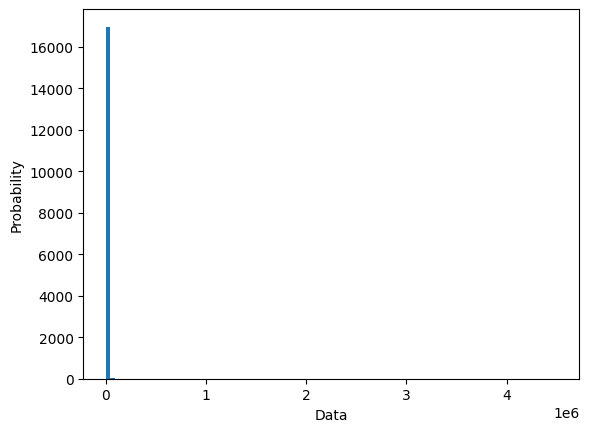

In [246]:
prices = train['Price'].values
plt.hist(prices, bins=100)
plt.xlabel('Data')
plt.ylabel('Probability')

In [247]:
train = train[train['Price'] < train['Price'].quantile(.99)]

Text(0, 0.5, 'Probability')

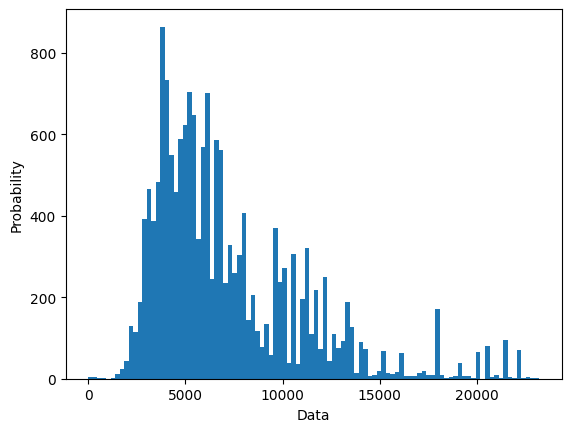

In [248]:
prices = train['Price'].values
plt.hist(prices, bins=100)
plt.xlabel('Data')
plt.ylabel('Probability')

In [249]:
train.shape

(16815, 104)

In [250]:
X = train.iloc[:,:-1].values
y = train.iloc[:, -1].values
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [251]:
X_train_cat = X[:15817]
y_train_cat = y[:15817]
X_test_cat = X[15817:]
y_test_cat = y[15817:]

In [252]:
X_train, X_val, y_train, y_val = train_test_split(X_train_cat, y_train_cat, test_size=0.2, random_state=0)

# Normalizing

In [ ]:
scaler = StandardScaler()
list_to_norm = list(X_train.columns[:5].values)
list_binary_features = list(X_train.columns[5:].values)
list_text = ['name_clean_list']

X_train_to_norm = X_train[list_to_norm]
X_val_to_norm = X_val[list_to_norm]

X_train_to_norm = scaler.fit_transform(X_train_to_norm)
X_val_to_norm = scaler.transform(X_val_to_norm)

X_train_final = np.c_[ X_train_to_norm, np.array(X_train[list_binary_features]), np.array(X_train[range(0,100)])]
X_val_final  = np.c_[ X_val_to_norm, np.array(X_val[list_binary_features]), np.array(X_train[range(0,100)]) ]

In [ ]:
print(X_train_final.shape,X_val_final.shape, y_train_log.shape,y_val_log.shape)

(12653, 103) (3164, 103) (12653, 1) (3164, 1)


# Catboost

In [235]:
! pip install catboost

In [253]:
from catboost import CatBoostRegressor, Pool

clf = CatBoostRegressor (loss_function='RMSE')

train_dataset = Pool(data=X_train, label=y_train)
eval_dataset = Pool(data=X_val, label=y_val)

In [254]:
clf.fit(train_dataset, use_best_model=True, verbose=0, eval_set=eval_dataset)

In [255]:
y_pred = clf.predict(Pool(data=X_test_cat))

print(f"MAPE: {mean_absolute_percentage_error(y_test_cat, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test_cat, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_cat, y_pred))}")

MAPE: 0.06317936015538962
MAE: 358.3781732071633
RMSE: 711.8317659416622
